In [1]:
import pandas as pd
import numpy as np

from run_backtest import load_trackers
from utils import clean_stale_prices

from entities import EM_CDS_TRACKER_DICT, FX_TRACKER_DICT
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA

from matplotlib.ticker import PercentFormatter
import matplotlib.pyplot as plt

c:\Users\pcampos\Anaconda3\envs\bwgi\lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


In [2]:
def plot_bar_contribution(
    heights: pd.Series,
    title: str,
):
    plt.figure(figsize=(10, 6))
    cumulative_values = np.cumsum(heights) - heights
    plt.bar(
        range(1, len(heights) + 1),
        heights,
        bottom=cumulative_values,
        alpha=0.5,
        align="center",
        label="Explained Variance",
    )

    plt.ylim(0, 1)
    plt.xlabel("Componente Principal", labelpad=10)
    plt.ylabel("Explicação da Variância", labelpad=10)
    plt.title(title, fontweight="bold", pad=20)

    plt.gca().xaxis.set_major_locator(plt.MultipleLocator(1))
    plt.gca().xaxis.set_minor_locator(plt.MultipleLocator(0.5))
    plt.grid(True, which="major", axis="y", linestyle="--", linewidth=0.75)
    plt.grid(True, which="minor", axis="x", linestyle="--", linewidth=0.75)

    plt.gca().tick_params(axis="x", which="both", length=0)

    plt.gca().yaxis.set_major_formatter(PercentFormatter(1))

    plt.xticks(range(1, len(heights) + 1))
    plt.tight_layout()
    plt.show()


def plot_historical_correlation(
    rolling_corr: pd.Series,
    total_correlation: float,
    title: str = "Correlação entre a Primeira Componente Principal de FX e a de CDS",
    y_lim: tuple[float, float] = (0, 1),
):
    plt.figure(figsize=(10, 6))
    rolling_corr.plot()
    plt.axhline(
        total_correlation,
        color="red",
        linestyle="--",
        label="Correlação Média do Período",
    )
    plt.grid(True, which="both", axis="both", linestyle="--", linewidth=0.75)
    plt.xlabel(None)
    plt.xlim(rolling_corr.dropna().index.min(), rolling_corr.index.max())
    plt.ylim(*y_lim)
    plt.legend(ncol=2)
    plt.title(title, fontweight="bold", pad=20)
    plt.tight_layout()
    plt.show()

In [3]:
cds = load_trackers(EM_CDS_TRACKER_DICT).rename(columns=lambda col: col + "_cds")
fx = load_trackers(FX_TRACKER_DICT).rename(columns=lambda col: col + "_fx")

cds = pd.concat([clean_stale_prices(cds[col].copy()) for col in cds], axis=1)
fx = pd.concat([clean_stale_prices(fx[col].copy()) for col in fx], axis=1)

In [4]:
RETURN_WINDOW = 21

df_cds = (
    np.log(cds)
    .fillna(method="ffill", limit=5)
    .diff(RETURN_WINDOW)
    .dropna(how="all")
    .copy()
)
df_cds = df_cds.loc["2009-12-10":].dropna(how="any", axis=1)
df_cds = (df_cds - df_cds.mean())/ df_cds.std()

df_fx = (
    np.log(fx)
    .fillna(method="ffill", limit=5)
    .diff(RETURN_WINDOW)
    .dropna(how="all")
    .copy()
)
df_fx = df_fx.loc["2004-08-02":].dropna(how="any", axis=1)
df_fx = (df_fx - df_fx.mean()) / df_fx.std()

new_index = df_fx.dropna().index.intersection(df_cds.dropna().index)
df_fx = df_fx.reindex(new_index)
df_cds = df_cds.reindex(new_index)

df_all = pd.concat([df_cds, df_fx], axis=1).dropna()
df_all

,AED_cds,BRL_cds,CNY_cds,CLP_cds,COP_cds,MYR_cds,MXN_cds,PAB_cds,PEN_cds,PHP_cds,...,IDR_fx,INR_fx,MXN_fx,PLN_fx,RUB_fx,SGD_fx,THB_fx,TRY_fx,TWD_fx,ZAR_fx
date,,,,,,,,,,,,,,,,,,,,,
2009-12-10,-5.818572,-0.205412,0.387888,-0.546996,-0.318124,0.354487,0.080844,-0.034334,-0.176948,0.218753,...,-0.194076,-0.207938,0.833286,-0.110824,-0.865625,-0.163034,0.127322,-0.181413,-0.224730,-0.268933
2009-12-11,-5.426299,-0.255770,0.407027,-0.243386,-0.204364,0.241096,0.069403,-0.020279,-0.176972,0.185985,...,-0.268019,-0.206531,0.774674,-0.396410,-0.718651,-0.207831,0.166343,-0.221624,0.051875,-0.218516
2009-12-14,-4.721629,-0.020626,0.464304,-0.209670,0.061074,0.311319,0.339194,0.205948,0.183532,0.491433,...,-0.209953,-0.052248,0.842180,-0.540887,-0.610800,-0.156789,0.199018,-0.174663,0.024579,0.209765
2009-12-15,-4.865340,0.046435,0.599268,-0.158993,0.146201,0.395705,0.361252,0.403463,0.258233,0.700048,...,-0.534144,-0.250513,0.905066,-1.060399,-0.676545,-0.378255,0.162162,-0.230927,-0.010224,0.210429
2009-12-16,-4.802993,-0.180183,0.328906,-0.496161,-0.071784,0.324872,-0.054665,-0.006454,-0.072036,0.297193,...,-0.373106,-0.467392,0.741262,-1.152270,-0.825815,-0.483938,-0.013489,-0.301106,-0.550799,0.064678
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-09-27,-0.123816,0.105010,0.131783,-0.051761,-0.244408,0.068913,-0.112849,1.141345,0.041474,0.134203,...,0.629810,0.114422,-0.076918,0.225527,-0.174028,0.945128,2.094069,0.715700,0.255619,0.942175
2024-09-30,-0.189916,0.188038,0.069507,-0.010384,-0.190619,0.025245,0.033931,1.140526,0.075297,0.098593,...,0.502706,0.029878,0.464058,0.221326,-0.105188,0.941172,2.299545,0.650540,0.519588,0.709611
2024-10-01,-0.289081,0.349032,0.038347,-0.037928,-0.103124,0.025245,0.099253,1.271268,0.086577,0.122354,...,0.482218,0.001092,-0.038097,-0.088798,-0.571731,0.588876,2.006394,0.634736,0.018806,0.553294


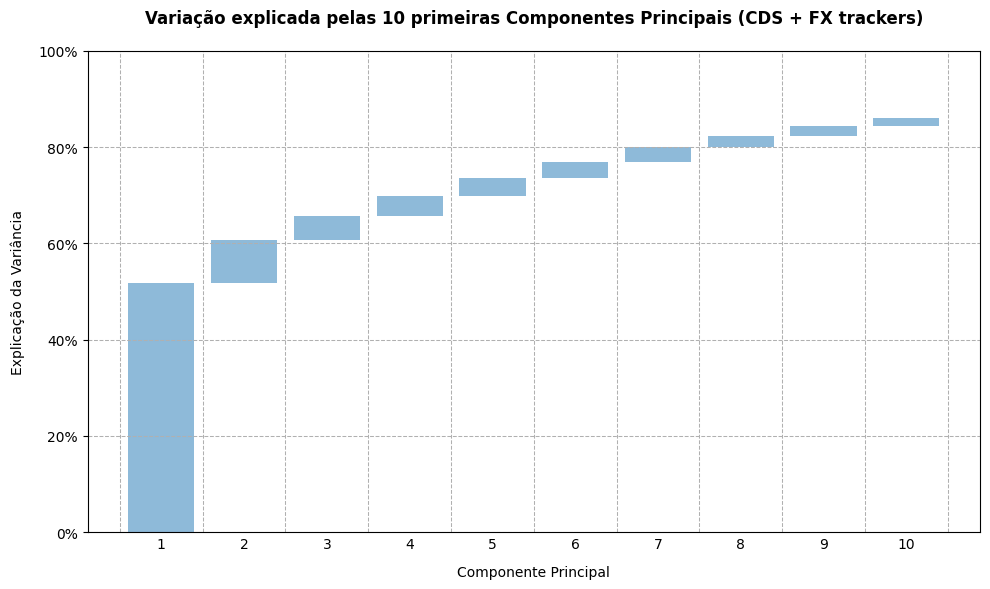

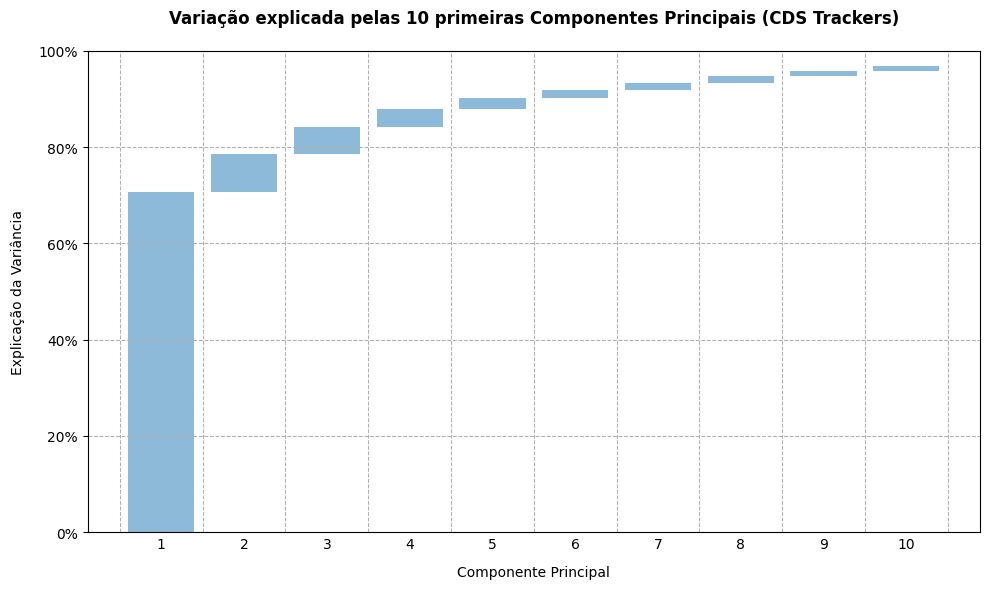

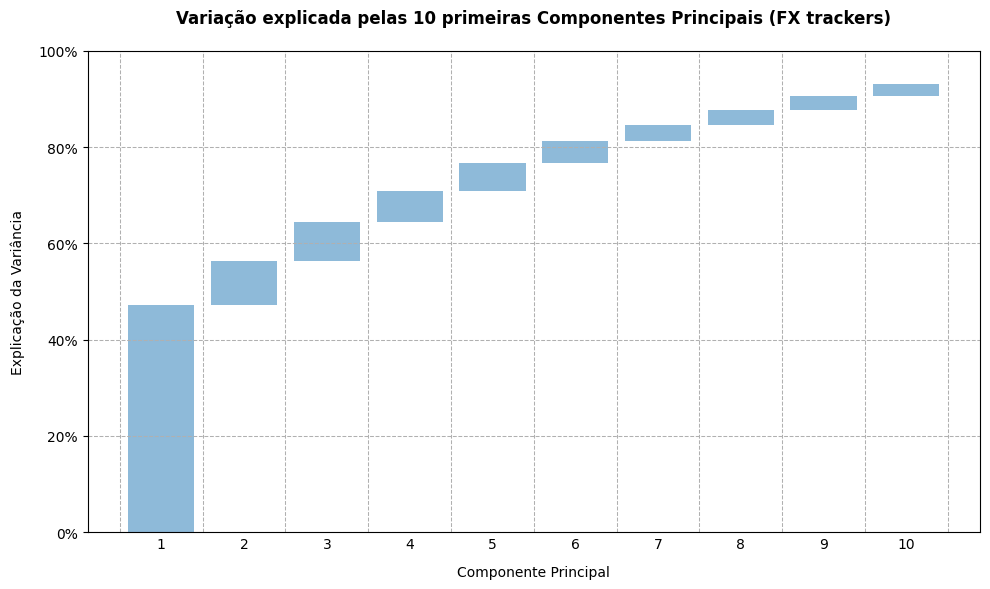

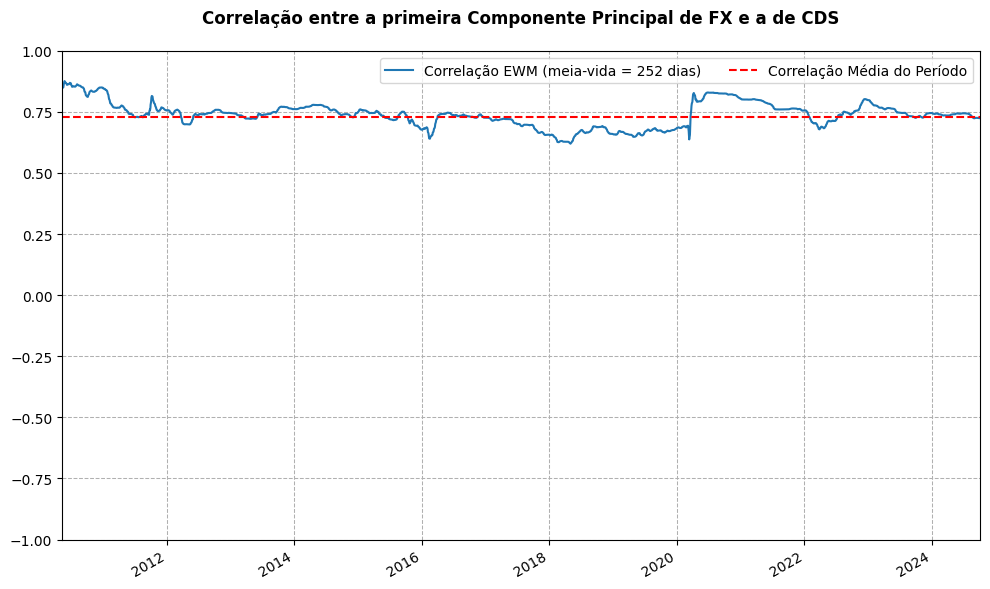

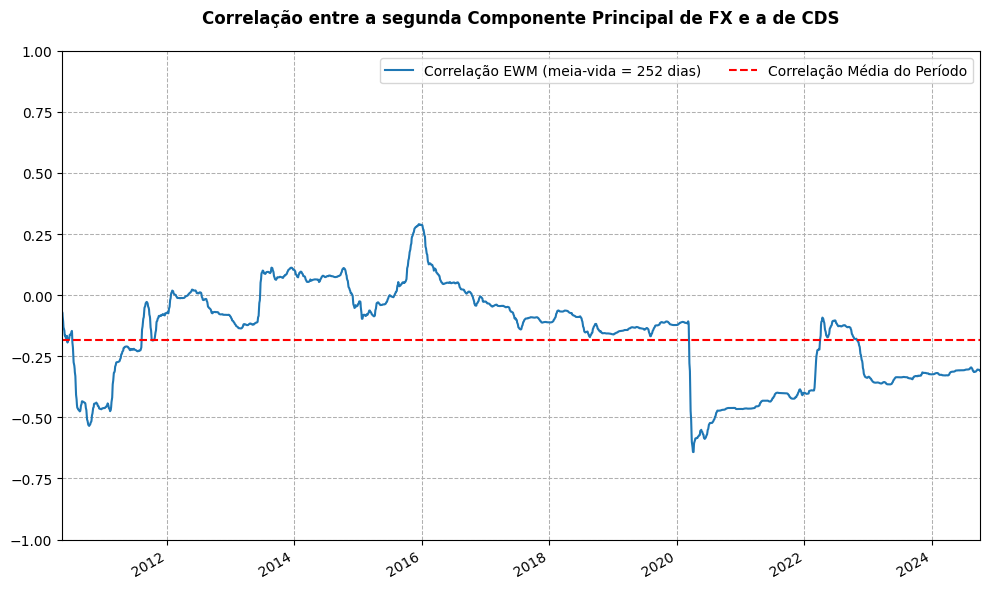

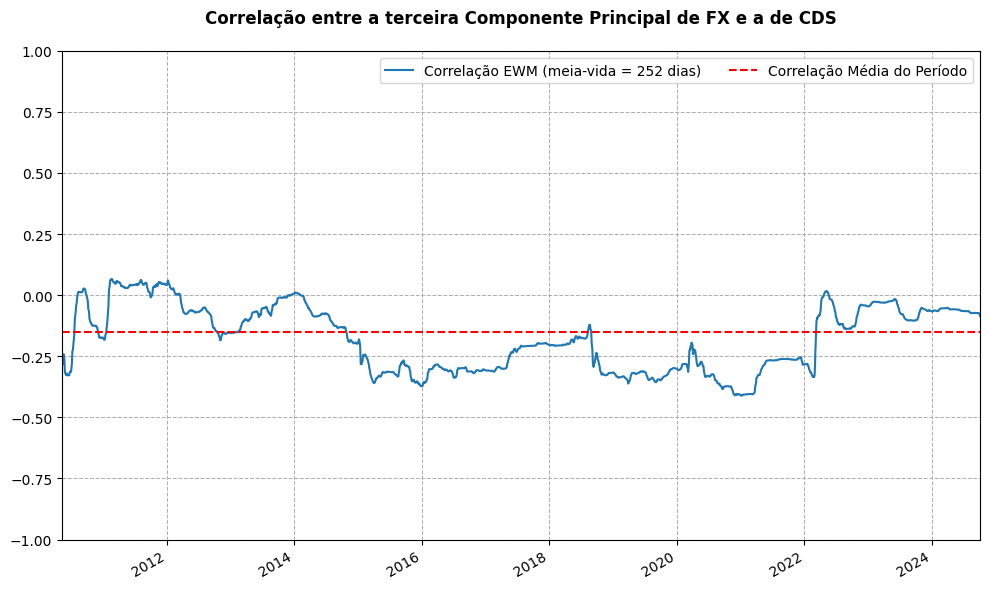

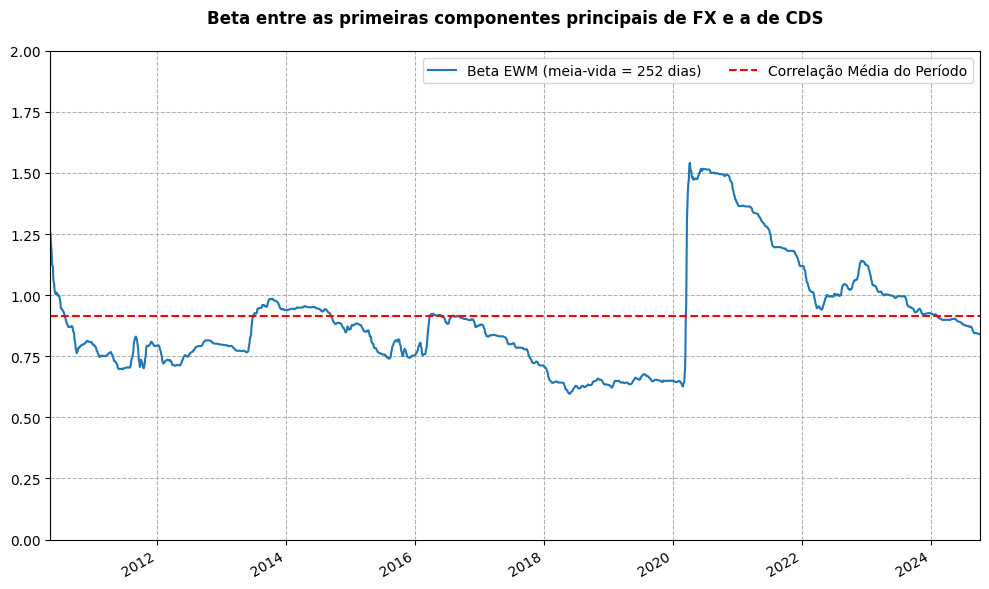

In [5]:
pca_all = PCA(n_components=10).fit(df_all)
plot_bar_contribution(
    pca_all.explained_variance_ratio_,
    "Variação explicada pelas 10 primeiras Componentes Principais (CDS + FX trackers)",
)
########################################################################################
pca_cds = PCA(n_components=10).fit(df_cds.dropna())
explained_variance_ratio = pca_cds.explained_variance_ratio_
plot_bar_contribution(
    pca_cds.explained_variance_ratio_,
    "Variação explicada pelas 10 primeiras Componentes Principais (CDS Trackers)",
)
########################################################################################
pca_fx = PCA(n_components=10).fit(df_fx.dropna())
explained_variance_ratio = pca_fx.explained_variance_ratio_
plot_bar_contribution(
    pca_fx.explained_variance_ratio_,
    "Variação explicada pelas 10 primeiras Componentes Principais (FX trackers)",
)
########################################################################################
pca_1_fx = pd.DataFrame(pca_fx.fit_transform(df_fx), index=new_index).iloc[:, 0]
pca_1_cds = pd.DataFrame(pca_cds.fit_transform(df_cds), index=new_index).iloc[:, 0]
plot_historical_correlation(
    pca_1_cds.ewm(halflife=252)
    .corr(pca_1_fx)
    .iloc[100:]
    .rename("Correlação EWM (meia-vida = 252 dias)"),
    pca_1_cds.corr(pca_1_fx),
    title="Correlação entre a primeira Componente Principal de FX e a de CDS",
    y_lim=(-1, 1),
)
########################################################################################
pca_2_fx = pd.DataFrame(pca_fx.fit_transform(df_fx), index=new_index).iloc[:, 1]
pca_2_cds = pd.DataFrame(pca_cds.fit_transform(df_cds), index=new_index).iloc[:, 1]
plot_historical_correlation(
    pca_2_cds.ewm(halflife=252)
    .corr(pca_2_fx)
    .iloc[100:]
    .rename("Correlação EWM (meia-vida = 252 dias)"),
    pca_2_cds.corr(pca_2_fx),
    title="Correlação entre a segunda Componente Principal de FX e a de CDS",
    y_lim=(-1, 1),
)
########################################################################################
pca_3_fx = pd.DataFrame(pca_fx.fit_transform(df_fx), index=new_index).iloc[:, 2]
pca_3_cds = pd.DataFrame(pca_cds.fit_transform(df_cds), index=new_index).iloc[:, 2]
plot_historical_correlation(
    pca_3_cds.ewm(halflife=252)
    .corr(pca_3_fx)
    .iloc[100:]
    .rename("Correlação EWM (meia-vida = 252 dias)"),
    pca_3_cds.corr(pca_3_fx),
    title="Correlação entre a terceira Componente Principal de FX e a de CDS",
    y_lim=(-1, 1),
)
########################################################################################
plot_historical_correlation(
    (pca_1_cds.ewm(halflife=252).cov(pca_1_fx) / pca_1_fx.ewm(halflife=252).var())
    .iloc[100:]
    .rename("Beta EWM (meia-vida = 252 dias)"),
    pca_1_cds.cov(pca_1_fx) / pca_1_fx.var(),
    y_lim=(0, 2),
    title="Beta entre as primeiras componentes principais de FX e a de CDS",
)

# OLD

In [6]:
from scipy import stats
# Perform linear regression
slope, intercept, r_value, p_value, std_err = stats.linregress(pca_1_cds, pca_1_fx)

# r_value is the correlation coefficient, so R² is r_value squared
r_squared = r_value**2

print(f"R²: {r_squared}")

R²: 0.5335863738075001


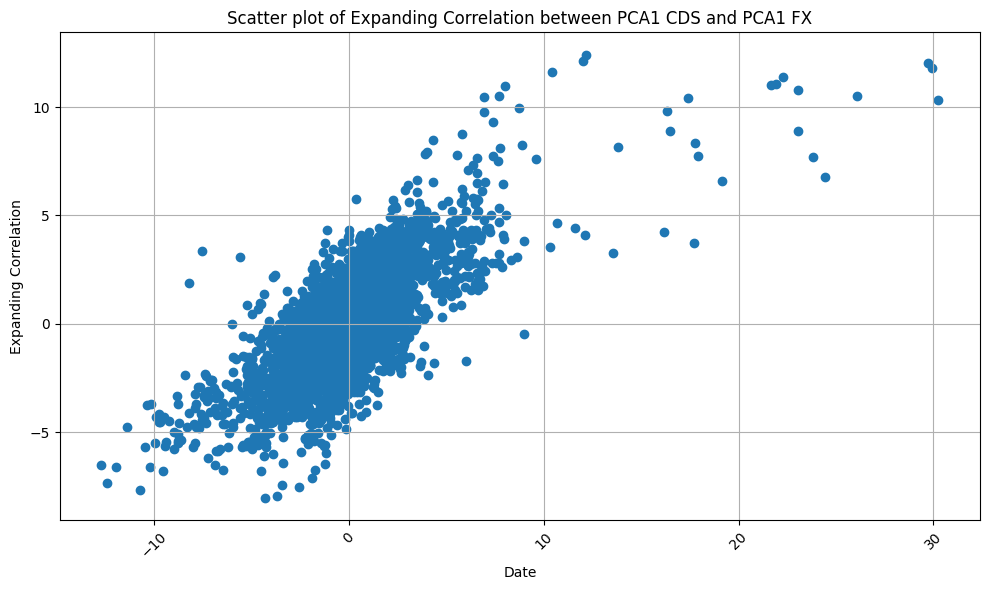

In [7]:
plt.figure(figsize=(10, 6))
plt.scatter(pca_1_cds, pca_1_fx.reindex(pca_1_cds.index))
plt.title("Scatter plot of Expanding Correlation between PCA1 CDS and PCA1 FX")
plt.xlabel("Date")
plt.ylabel("Expanding Correlation")
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()